# Chloe Ting Data Analysis

Data collected using `data-collection-chrome-extension` were exported to CSV file.
This data is from https://www.youtube.com/watch?v=2pLT-olgUJs

## Set up plot function

In [75]:
from CONSTANTS import CLASS_NAMES, FEATURES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

csv_filepath = './data/2020-07-26_06-35-07.csv'
df = pd.read_csv(csv_filepath, sep=',', header=0)

# Get dataframes for time and label
time = df['timestamp'] 
label = df['class']

# Plot feature value and its difference between neighboring values
def plotFeature(sub_part, divide_factor, feature, delta, feature_name):
    fig, ax = plt.subplots(2, 1, figsize=(15,16))

    time_split = np.array_split(time, divide_factor)
    label_split = np.array_split(label, divide_factor)

    feature_split = np.array_split(feature, divide_factor)
    delta_split = np.array_split(delta, divide_factor)

    # Feature value
    ax[0].set_title(feature_name)
    ylim_1 = [min(feature), max(feature)]
    ax[0].set_ylim(ylim_1)
    ax[0].plot(time_split[sub_part], feature_split[sub_part], color='dodgerblue')
    ax[0].fill_between(time_split[sub_part], ylim_1[0], ylim_1[1], where=label_split[sub_part] == 0, color='lightcoral', alpha=0.2)

    # Delta (max diff between current and previous 2 values)
    ax[1].set_title('Delta ' + feature_name)
    ylim_2 = [min(delta), max(delta)]
    ax[1].set_ylim(ylim_2)
    ax[1].plot(time_split[sub_part], delta_split[sub_part], color='darkorange')
    ax[1].fill_between(time_split[sub_part], ylim_2[0], ylim_2[1], where=label_split[sub_part] == 0, color='lightcoral', alpha=0.2)

    plt.show()

## RMS

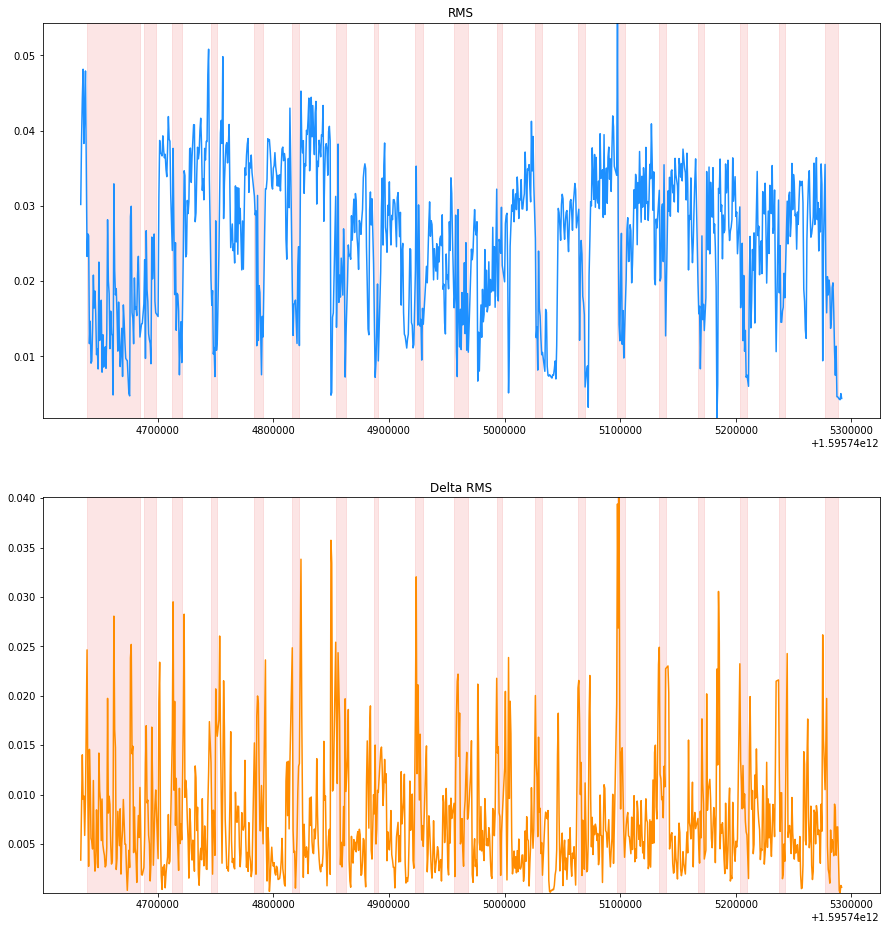

In [95]:
RMS_DIVIDE_FACTOR = 1
RMS_PART = 0
rms = df[FEATURES['RMS']]
delta_rms = df[FEATURES['DELTA_RMS']]

plotFeature(RMS_PART, RMS_DIVIDE_FACTOR, rms, delta_rms, 'RMS')

## Energy

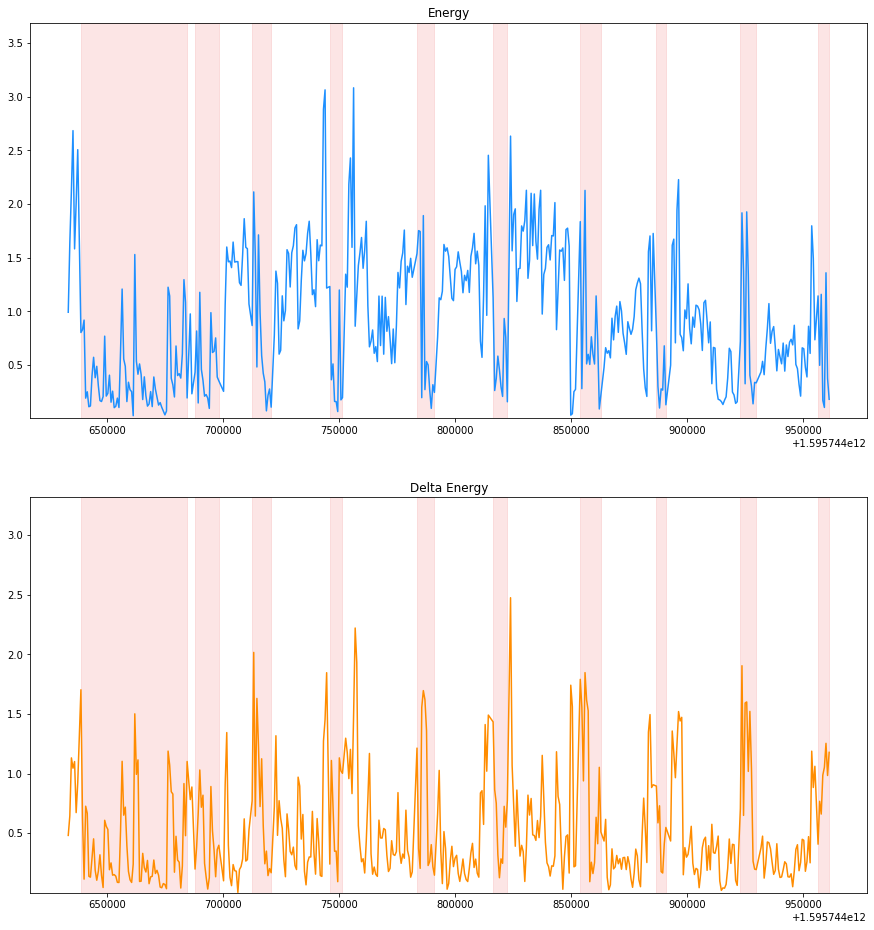

In [96]:
ENERGY_DIVIDE_FACTOR = 2
ENERGY_PART = 0
energy = df[FEATURES['ENERGY']]
delta_energy = df[FEATURES['DELTA_ENERGY']]

plotFeature(ENERGY_PART, ENERGY_DIVIDE_FACTOR, energy, delta_energy, 'Energy')

## Spectral Centroid

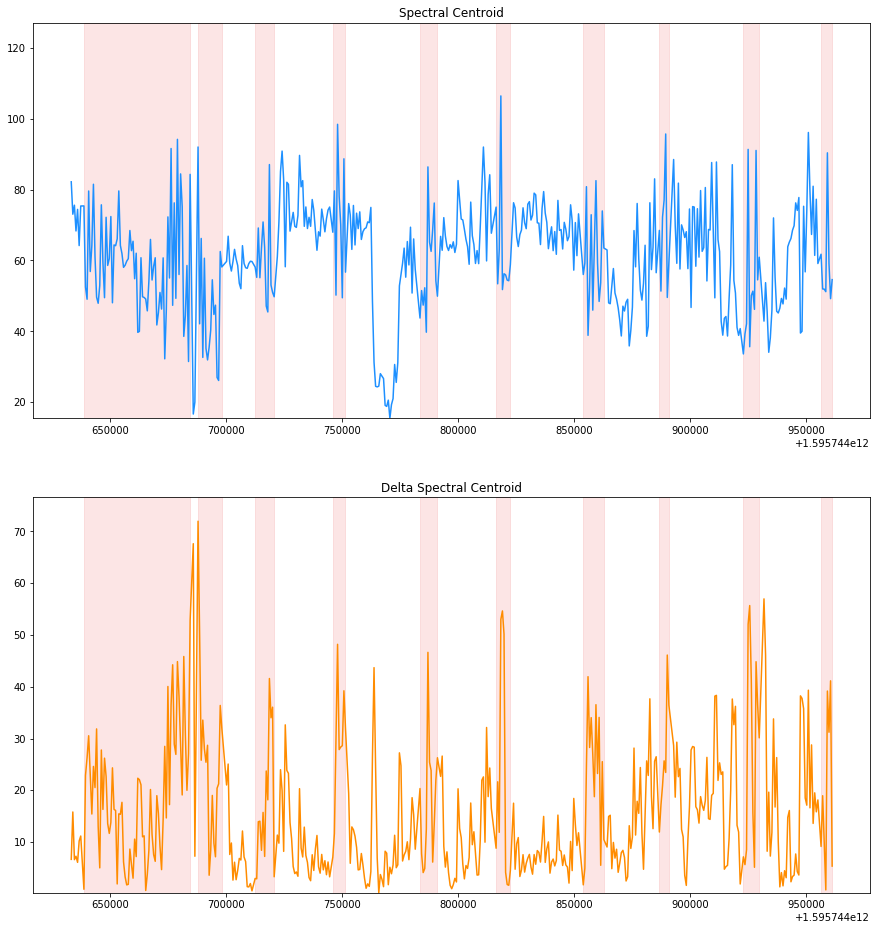

In [97]:
SP_CENTROID_DIVIDE_FACTOR = 2
SP_CENTROID_PART = 0
sp_centriod = df[FEATURES['SPECTRAL_CENTROID']]
delta_sp_centriod = df[FEATURES['DELTA_SPECTRAL_CENTROID']]

plotFeature(SP_CENTROID_PART, SP_CENTROID_DIVIDE_FACTOR, sp_centriod, delta_sp_centriod, 'Spectral Centroid')

## Spectral Flatness

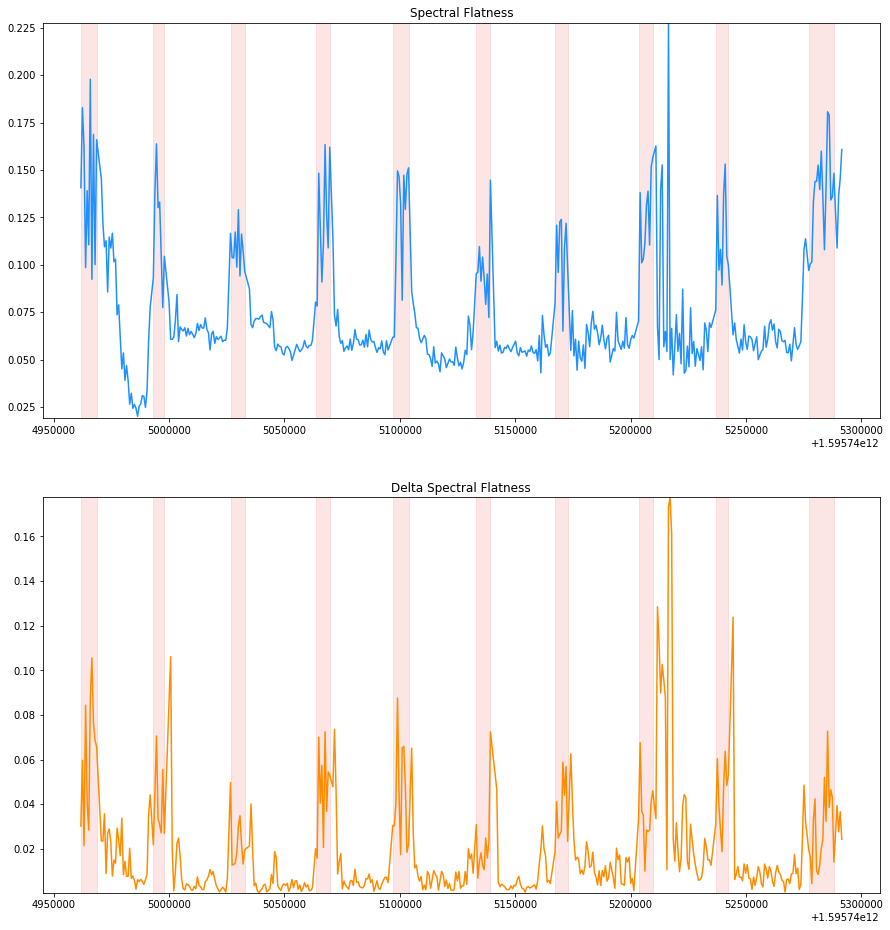

In [98]:
SP_FLATNESS_DIVIDE_FACTOR = 2
SP_FLATNESS_PART = 1
sp_flatness = df[FEATURES['SPECTRAL_FLATNESS']]
delta_sp_flatness = df[FEATURES['DELTA_SPECTRAL_FLATNESS']]

plotFeature(SP_FLATNESS_PART, SP_FLATNESS_DIVIDE_FACTOR, sp_flatness, delta_sp_flatness, 'Spectral Flatness')

## Spectral Rolloff

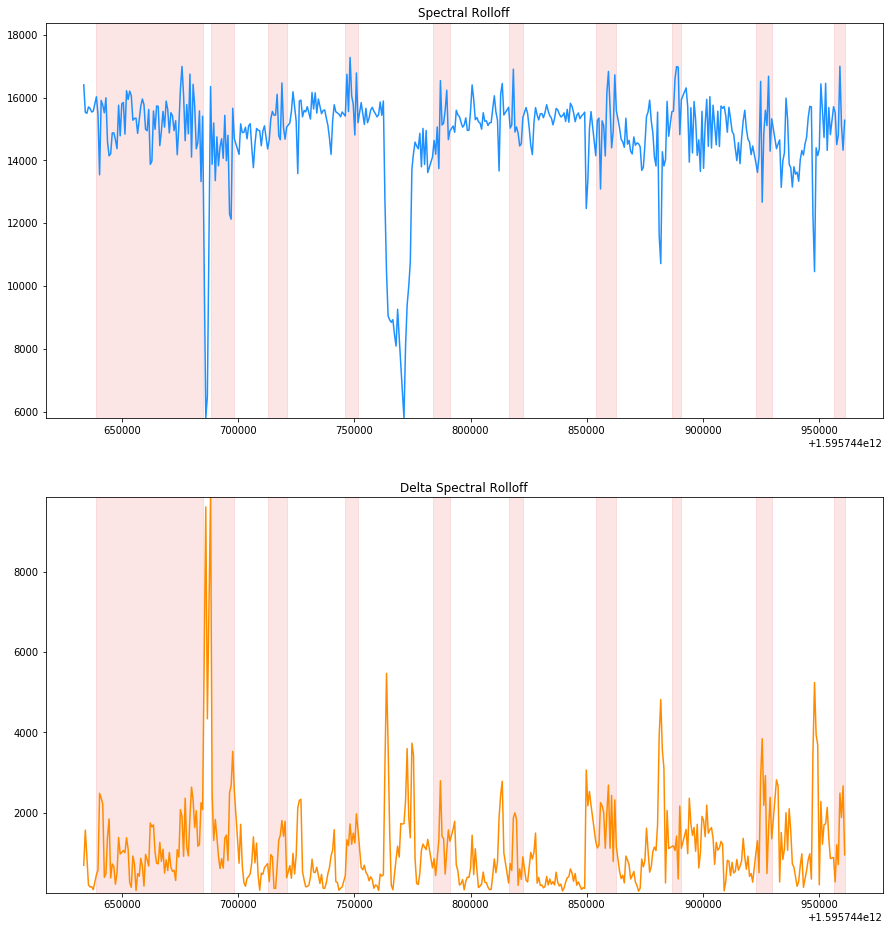

In [99]:
SP_ROLLOFF_DIVIDE_FACTOR = 2
SP_ROLLOFF_PART = 0
sp_rolloff = df[FEATURES['SPECTRAL_ROLLOFF']]
delta_sp_rolloff = df[FEATURES['DELTA_SPECTRAL_ROLLOFF']]

plotFeature(SP_ROLLOFF_PART, SP_ROLLOFF_DIVIDE_FACTOR, sp_rolloff, delta_sp_rolloff, 'Spectral Rolloff')

## Spectral Skewness

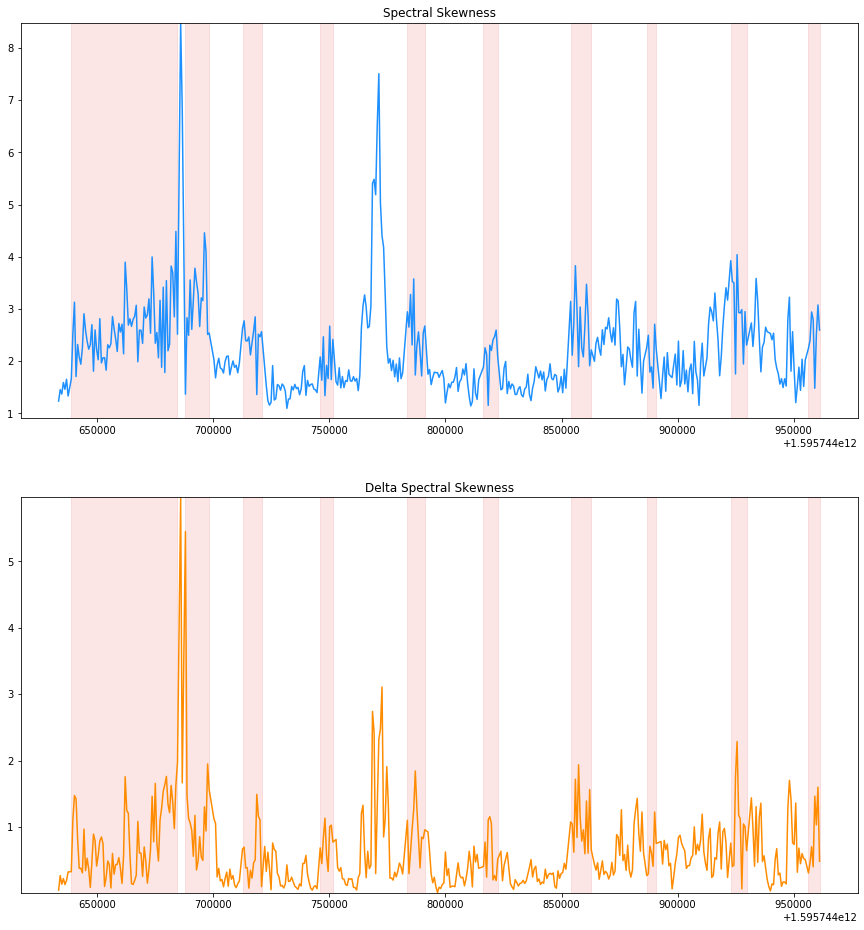

In [100]:
SP_SKEWNESS_DIVIDE_FACTOR = 2
SP_SKEWNESS_PART = 0
sp_skewness = df[FEATURES['SPECTRAL_SKEWNESS']]
delta_sp_skewness = df[FEATURES['DELTA_SPECTRAL_SKEWNESS']]

plotFeature(SP_SKEWNESS_PART, SP_SKEWNESS_DIVIDE_FACTOR, sp_skewness, delta_sp_skewness, 'Spectral Skewness')

##  Perceptual Spread

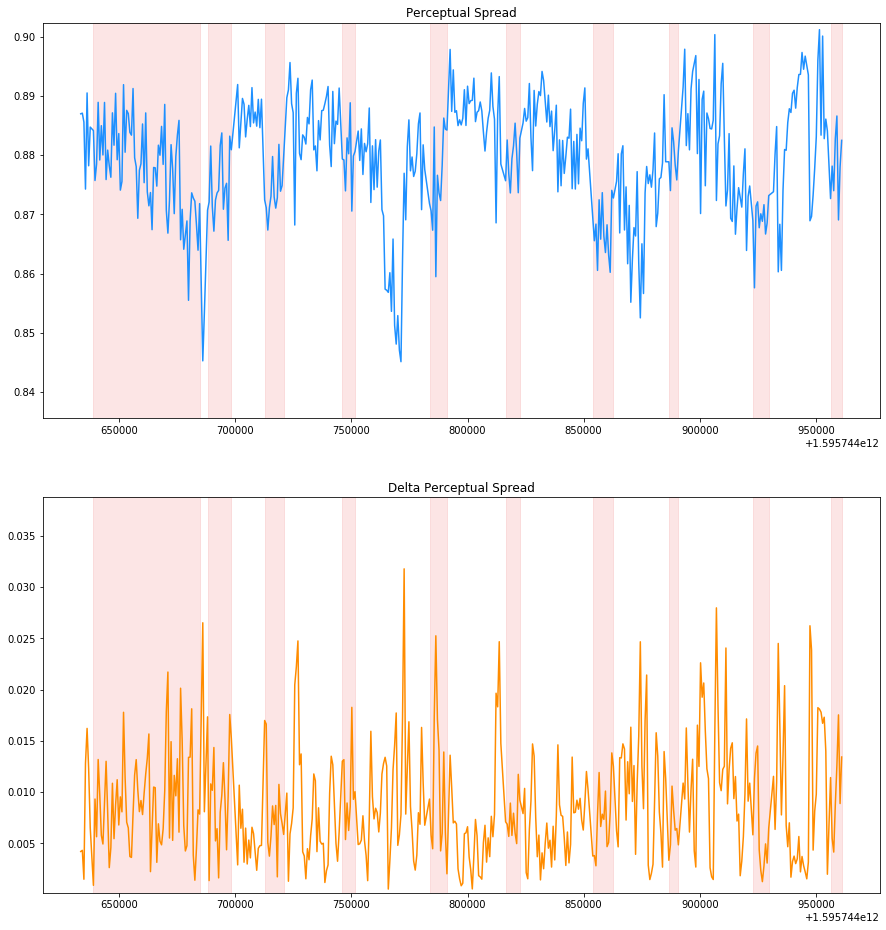

In [101]:
PC_SPREAD_DIVIDE_FACTOR = 2
PC_SPREAD_PART = 0
pc_spread = df[FEATURES['PERCEPTUAL_SPREAD']]
delta_pc_spread = df[FEATURES['DELTA_PERCEPTUAL_SPREAD']]

plotFeature(PC_SPREAD_PART, PC_SPREAD_DIVIDE_FACTOR, pc_spread, delta_pc_spread, 'Perceptual Spread')

## Perceptual Sharpness

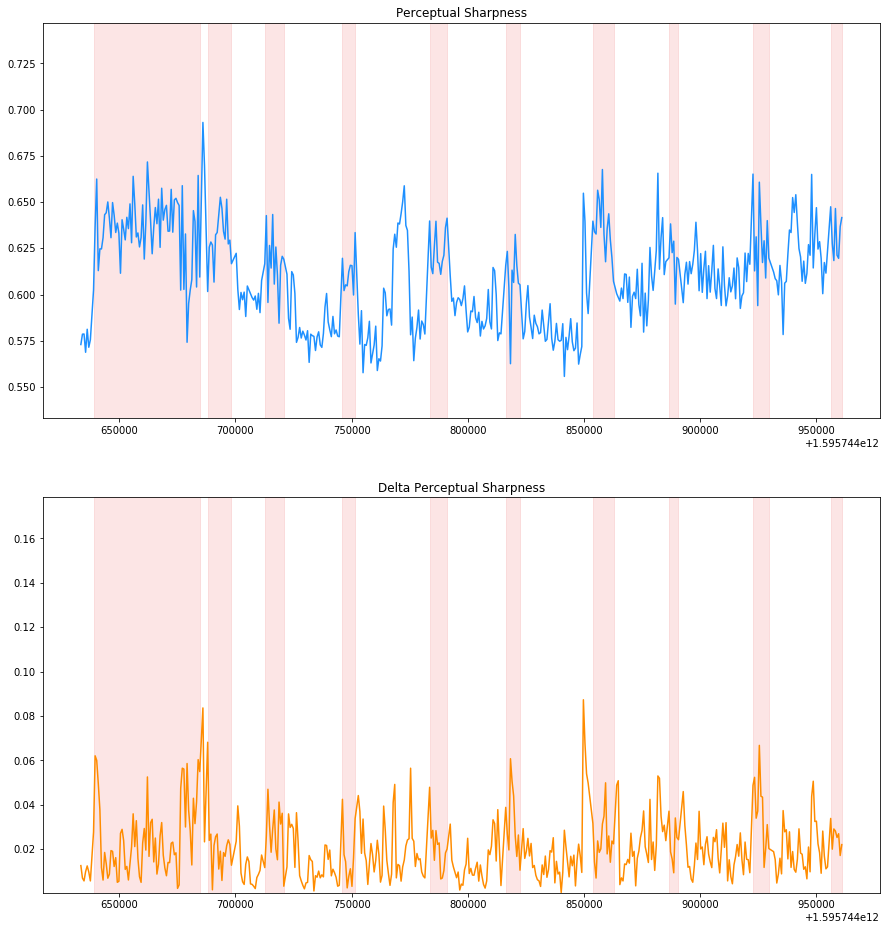

In [102]:
PC_SHARPNESS_DIVIDE_FACTOR = 2
PC_SHARPNESS_PART = 0
pc_sharpness = df[FEATURES['PERCEPTUAL_SHARPNESS']]
delta_pc_sharpness = df[FEATURES['DELTA_PERCEPTUAL_SHARPNESS']]

plotFeature(PC_SHARPNESS_PART, PC_SHARPNESS_DIVIDE_FACTOR, pc_sharpness, delta_pc_sharpness, 'Perceptual Sharpness')

## MFCC

In [ ]:
def plotMFCC():
    